In [41]:
from manifold_flow.flows import ManifoldFlow
from manifold_flow import transforms
from manifold_flow.architectures.vector_transforms import create_vector_transform

import numpy as np
import torch
from torch.utils.data import TensorDataset
from tqdm import tqdm
from pathlib import Path
from math import sqrt
import matplotlib.pyplot as plt

In [3]:
# Define M-Flow model
mflow = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=transforms.ConditionalAffineScalarTransform(features=1),
    outer_transform=create_vector_transform(dim=2, flow_steps=16)
)

mflow.load_state_dict(torch.load("../models/spirals/spiral_mflow_nrotations_1.2_successful_A.pt"))

<All keys matched successfully>

### Load "Two Spirals" dataset

In [43]:
# Load the "Two Spirals" dataset from disk
loaded_dataset = torch.load("../data/two_spirals/spiral_dataset_20k.pt")

# Extract X from the loaded dataset
X = loaded_dataset["X"]

In [4]:
# Sample many points from the model to visualise the learned manifold
mflow.eval()
manifold_points = mflow.sample(n=10_000).detach().numpy()

In [5]:
def generate_grid_tensor(
        n_points_per_axis: int,
        min_val:           float,
        max_val:           float
    ) -> torch.Tensor:
    linspace    = torch.linspace(min_val, max_val, n_points_per_axis)
    x, y        = torch.meshgrid(linspace, linspace, indexing="ij")
    grid_points = torch.stack([x.flatten(), y.flatten()], dim=-1)
    return grid_points

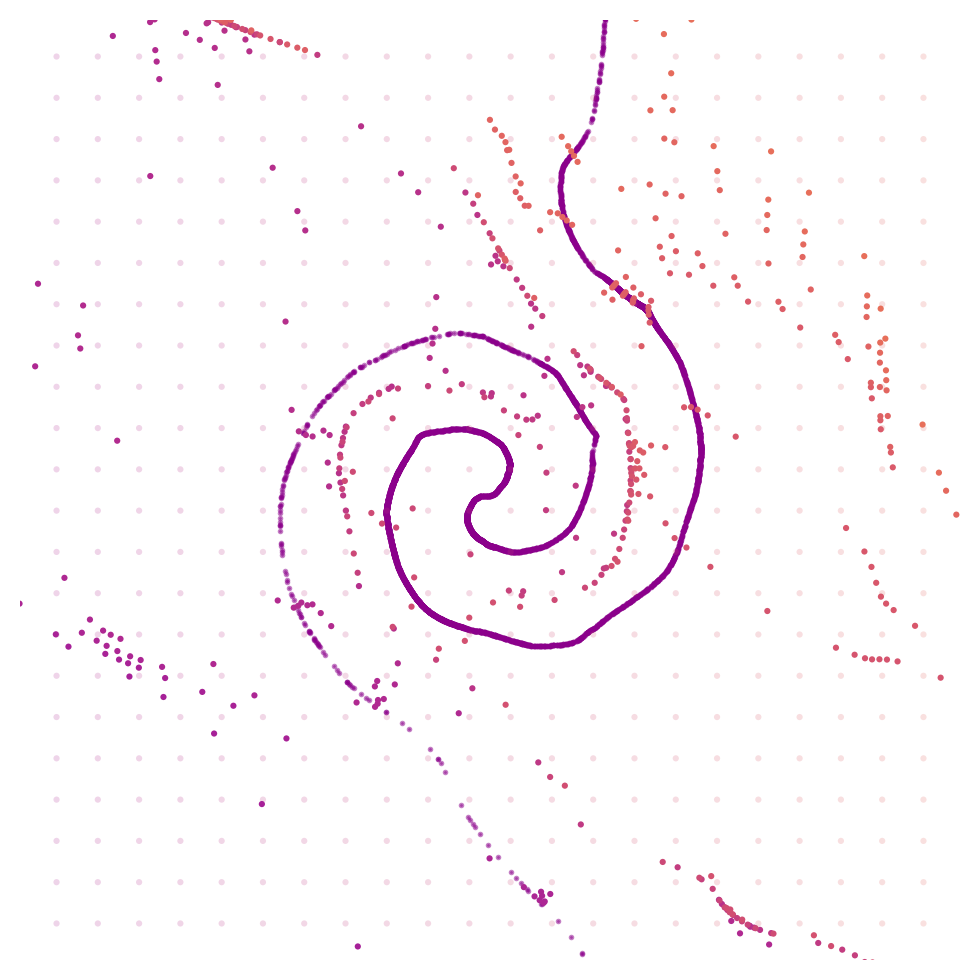

In [6]:
# Generate random colours for the sample points
n_samples     = 10000
random_values = torch.rand(n_samples)
colours       = plt.colormaps["hsv"](random_values)[:, :3]
grid_colours  = plt.colormaps["plasma"](np.linspace(0, 1, n_samples))[:, :3]

# Generate poins on a regular grid
grid_points = generate_grid_tensor(int(sqrt(n_samples)), -10, 10)

# Transform grid points from altent space to ambient data space
points_proj = mflow.outer_transform.inverse(grid_points)[0].detach().numpy()

# Set colours for grid points with y = 0 to pink
zero_levelset_mask = (grid_points[:, 1].abs() < 0.0000001)
zero_levelset_idxs = torch.nonzero(zero_levelset_mask, as_tuple=True)[0]
grid_colours[zero_levelset_idxs] = torch.tensor([1, 0, 1])

# Define arrays used for plotting the projection vectors via `plt.quiver` 
# x_start, y_start = grid_points.T.numpy()
# x_end,   y_end   = points_proj.T
# dx               = x_end - x_start
# dy               = y_end - y_start

# Normalise vectors for visual clarity (optional)
# norm = np.linalg.norm(np.array([dx, dy]), axis=0) * 4
# dx  /= np.where(norm > 1, norm, 1)  # Normalise vectors with norm > 1
# dy  /= np.where(norm > 1, norm, 1)  # Normalise vectors with norm > 1

# Plotting
grid_colours = grid_colours[:grid_points.shape[0]]
plt.figure(figsize=(5, 5), dpi=200)
plt.scatter(*manifold_points.T, s=1, alpha=0.5, c="darkmagenta")
plt.scatter(*grid_points.T,     s=5, alpha=0.2,   c=grid_colours, lw=0)
plt.scatter(*points_proj.T,     s=5, alpha=1,   c=grid_colours, lw=0)

# Plot projection vectors
# plt.quiver(x_start, y_start, dx, dy, scale_units="xy", scale=1, color=grid_colours)

plt.gca().set_aspect("equal", adjustable="box")
plt.axis("off")
plt.xlim(-2.3, 2.3)
plt.ylim(-2.3, 2.3)
plt.tight_layout()

# Transform a horizontal line from latent space to ambient space

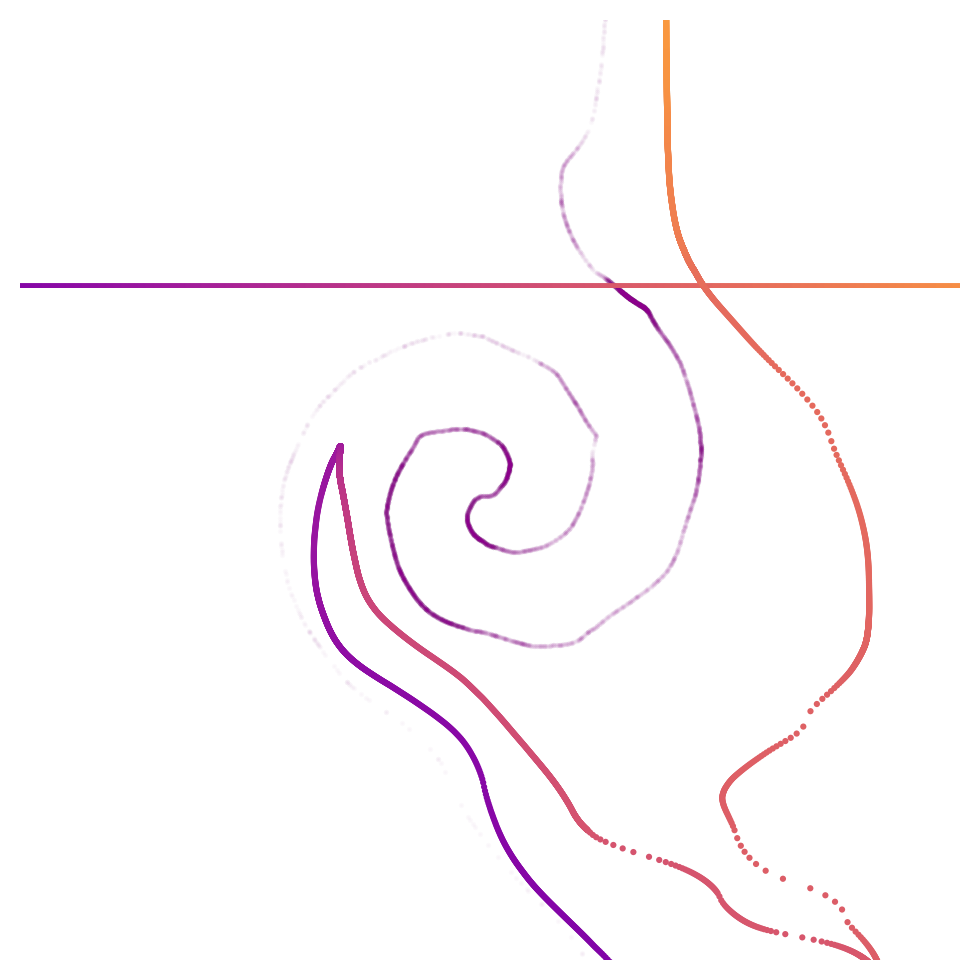

In [8]:
# Generate colours for the sample points
n_samples     = 10000
grid_colours  = plt.colormaps["plasma"](np.linspace(0, 1, n_samples))[:, :3]

# Generate samples and project them to the manifold
x_range = 5
y_val   = 1
xs = torch.linspace(-1, 1, n_samples) * x_range
ys = torch.ones_like(xs) * y_val
line_points = torch.column_stack([xs, ys])

# Transform points from latent space to ambiet space
points_proj = mflow.outer_transform.inverse(line_points)[0].detach().numpy()

# Plotting
grid_colours = grid_colours[:grid_points.shape[0]]
plt.figure(figsize=(5, 5), dpi=200)
plt.scatter(*manifold_points.T, s=1,  alpha=0.02, c="darkmagenta")
plt.scatter(*line_points.T, s=2, alpha=1,   c=grid_colours, lw=0)
plt.scatter(*points_proj.T, s=5, alpha=1,   c=grid_colours, lw=0)

plt.gca().set_aspect("equal", adjustable="box")
plt.axis("off")
plt.xlim(-2.3, 2.3)
plt.ylim(-2.3, 2.3)
plt.tight_layout()

## Generate animation frames of horizontal line transform

In [ ]:
# # Generate colours for the sample points
# n_samples    = 10_000
# grid_colours = plt.colormaps["plasma"](np.linspace(0, 1, n_samples))[:, :3]

# # Generate x values for the line
# x_range = 5
# xs      = torch.linspace(-1, 1, n_samples) * x_range

# # Create 120 frames
# num_frames = 120
# y_vals     = np.linspace(-2.3, 2.3, num_frames)

# for frame, y_val in enumerate(tqdm(y_vals)):
#     # Generate samples and project them to the manifold
#     ys = torch.ones_like(xs) * y_val
#     line_points = torch.column_stack([xs, ys])

#     # Transform points from latent space to ambient space
#     points_proj = mflow.outer_transform.inverse(line_points)[0].detach().numpy()

#     # Plotting
#     plt.figure(figsize=(5, 5), dpi=200)
#     plt.scatter(*manifold_points.T, s=1, alpha=0.02, c="darkmagenta")
#     plt.scatter(*line_points.T,     s=2, alpha=1,    c=grid_colours, lw=0)
#     plt.scatter(*points_proj.T,     s=5, alpha=1,    c=grid_colours, lw=0)

#     plt.gca().set_aspect("equal", adjustable="box")
#     plt.axis("off")
#     plt.xlim(-2.3, 2.3)
#     plt.ylim(-2.3, 2.3)
#     plt.tight_layout()

#     # Save the frame
#     plt.savefig(f"../figures/spiral_horizontal_line_transform/frame_{frame:03d}.png", bbox_inches="tight", pad_inches=0)
#     plt.close()

# Visualise transformed grid lines

tensor([[-0.7886,  0.4614]])


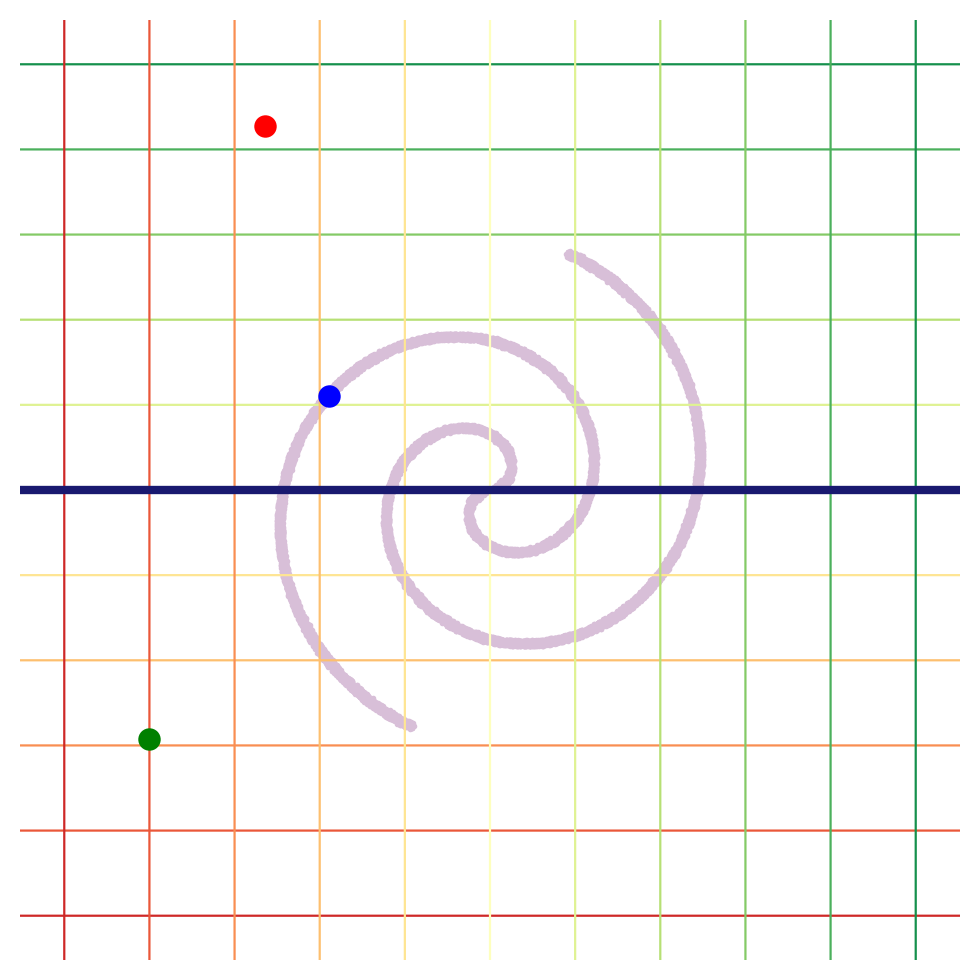

In [97]:
# Generate colours for the sample points
n_samples    = 10_000

# Generate samples and project them to the manifold
val_range = 2.5

plt.figure(figsize=(5, 5), dpi=200)

grid_density = 13
plt.scatter(*X.T, s=1, c="thistle")

for y_val in torch.linspace(-1, 1, grid_density) * val_range:
    if y_val.abs() < 0.1:
        color  = "midnightblue"
        lw     = 3
        zorder = 3
    else:
        color = plt.get_cmap("RdYlGn")((y_val / val_range + 1) / 2)
        lw    = 0.8
        zorder = 1
    
    xs          = torch.linspace(-val_range, val_range, n_samples)
    ys          = torch.full_like(xs, y_val.item())
    line_points = torch.column_stack([xs, ys])

    # Transform points from latent space to ambiet space
    points_proj = mflow.outer_transform.inverse(line_points)[0].detach().numpy()

    # Plotting
    plt.plot(line_points[:, 0], line_points[:, 1], lw=lw, color=color, zorder=zorder)
    # plt.plot(points_proj[:, 0], points_proj[:, 1], lw=lw, color=color, zorder=zorder)

for x_val in torch.linspace(-val_range, val_range, grid_density):
    ys          = torch.linspace(-val_range, val_range, n_samples)
    xs          = torch.full_like(xs, x_val.item())
    line_points = torch.column_stack([xs, ys])

    # Transform points from latent space to ambiet space
    points_proj = mflow.outer_transform.inverse(line_points)[0].detach().numpy()

    # Plotting
    color = plt.get_cmap("RdYlGn")((x_val / val_range + 1) / 2)
    plt.plot(line_points[:, 0], line_points[:, 1], lw=0.8, color=color)
    # plt.plot(points_proj[:, 0], points_proj[:, 1], lw=0.8, color=color)


# Demonstrate how a point x gets projected onto the manifold
# Pick point x
x = torch.tensor([[-1.1, 1.78]])

# Transform sample point into latent space
x_latent = mflow.encode(x)
x_latent_2d = mflow.outer_transform(x)[0].detach().numpy()

# Project sample onto manifold
x_proj   = mflow.decode(x_latent).detach()
print(x_proj)

plt.scatter(*x.T,        s=50, c="red", zorder=4)
plt.scatter(*x_latent_2d.T, s=50, c="green", zorder=4)
plt.scatter(*x_proj.T,   s=50, c="blue",  zorder=4)

plt.gca().set_aspect("equal", adjustable="box")
plt.axis("off")
plt.xlim(-2.3, 2.3)
plt.ylim(-2.3, 2.3)
plt.tight_layout()
# plt.savefig("../figures/report/grid_mflow.pdf")

In [13]:
def plot_grid_lines(
        mflow:     torch.nn.Module,
        n_samples: int,
        range:     float,
        axis:      str = "both",
        file_path: Path|None = None
    ):
    # Set up the plot
    plt.figure(figsize=(5, 5), dpi=200)
    plt.scatter(*manifold_points.T, s=1, alpha=1, c="plum")

    grid_values = np.linspace(-range, range, 33)
    
    for val in grid_values:
        # Generate points on a line grid
        if axis in ["x", "both"]:
            line_points = np.column_stack([np.full(n_samples, val), np.linspace(-range, range, n_samples)])
        if axis in ["y", "both"]:
            line_points = np.column_stack([np.linspace(-x_range, x_range, n_samples), np.full(n_samples, val)])
        
        # Convert to torch tensor and ensure float32 dtype
        line_points_tensor = torch.tensor(line_points, dtype=torch.float32)

        # Map grid points from latent space to ambient data space
        points_proj = mflow.outer_transform.inverse(line_points_tensor)[0].detach().numpy()
        
        # Plot the warped grid
        color = "hotpink" if abs(val) < 0.1 else "lightgray"
        lw    = 2         if abs(val) < 0.1 else 0.8
        plt.plot(points_proj[:, 0], points_proj[:, 1], lw=lw, color=color)

    # Finalize plot settings
    plt.gca().set_aspect("equal", adjustable="box")
    plt.axis("off")
    plt.xlim(-2.3, 2.3)
    plt.ylim(-2.3, 2.3)
    plt.tight_layout()

    if file_path is not None:
        plt.savefig(str(file_path))
    
    plt.close()
    plt.cla()
    plt.clf()

# Plot grid lines
range     = 5
n_samples = 10_000
file_path = Path(f"../figures/test.pdf")
plot_grid_lines(mflow, n_samples, range, axis="x", file_path=file_path)

<Figure size 640x480 with 0 Axes>